In [ ]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn.model_selection import train_test_split

# Enable mixed precision for Apple Silicon
tf.keras.mixed_precision.set_global_policy('mixed_float16')

def create_image_dataframe(image_path):
    """
    Create a DataFrame with image paths and taxonomic labels from directory structure.
    """
    image_paths, labels = [], []

    for folder in os.listdir(image_path):
        folder_path = os.path.join(image_path, folder)
        if not os.path.isdir(folder_path):  # Skip non-folder files
            continue

        family, genus, species = folder.split('_')
        for image_file in os.listdir(folder_path):
            if image_file.endswith(('.jpeg', '.jpg', '.png')):
                image_paths.append(os.path.join(folder_path, image_file))
                labels.append((family, genus, f"{genus} {species}"))

    df = pd.DataFrame(image_paths, columns=['image_path'])
    df[['family', 'genus', 'species']] = pd.DataFrame(labels, index=df.index)
    return df

def split_dataframe(df, test_size=0.2, val_size=0.1, random_state=42):
    """
    Split a DataFrame into train, validation, and test sets.
    """
    train_val, test = train_test_split(df, test_size=test_size, random_state=random_state, stratify=df['family'])
    train, val = train_test_split(train_val, test_size=val_size / (1 - test_size), random_state=random_state, stratify=train_val['family'])
    return train, val, test

def load_image_and_labels(image_path, family, genus, species, family_labels, genus_labels, species_labels, img_size=(224, 224)):
    """
    Load, resize, and preprocess an image, returning it with its taxonomic labels.
    """
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, img_size)
    image = tf.keras.applications.resnet.preprocess_input(image)

    family_label = tf.one_hot(tf.argmax(tf.equal(family_labels, family)), len(family_labels))
    genus_label = tf.one_hot(tf.argmax(tf.equal(genus_labels, genus)), len(genus_labels))
    species_label = tf.one_hot(tf.argmax(tf.equal(species_labels, species)), len(species_labels))

    return image, {"family": family_label, "genus": genus_label, "species": species_label}

def build_tf_dataset(df, batch_size=32, img_size=(224, 224)):
    """
    Build a TensorFlow dataset from a DataFrame with image paths and labels.
    """
    family_labels = tf.constant(df['family'].unique())
    genus_labels = tf.constant(df['genus'].unique())
    species_labels = tf.constant(df['species'].unique())

    dataset = tf.data.Dataset.from_tensor_slices((df['image_path'], df['family'], df['genus'], df['species']))
    dataset = dataset.map(
        lambda path, family, genus, species: load_image_and_labels(path, family, genus, species, family_labels, genus_labels, species_labels, img_size),
        num_parallel_calls=tf.data.AUTOTUNE
    )
    dataset = dataset.shuffle(len(df)).batch(batch_size).prefetch(tf.data.AUTOTUNE)

    return dataset, list(family_labels.numpy()), list(genus_labels.numpy()), list(species_labels.numpy())

def predict_image(image_path, model, family_labels, genus_labels, species_labels, image_size=(224,224) ,top_k=3):
    """
    Predict the top-k family, genus, and species from an image using a trained model,
    and display the image with predictions.

    Args:
    - image_path (str): Path to the image file.
    - model (tf.keras.Model): The trained model.
    - family_labels (list): List of family labels.
    - genus_labels (list): List of genus labels.
    - species_labels (list): List of species labels.
    - top_k (int): Number of top predictions to return.

    Returns:
    - top_k_family: List of tuples (family, confidence) for top k family predictions.
    - top_k_genus: List of tuples (genus, confidence) for top k genus predictions.
    - top_k_species: List of tuples (species, confidence) for top k species predictions.
    """

    # Load and preprocess the image
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, image_size)
    img = tf.expand_dims(img, 0)  # Add batch dimension

    # Predict family, genus, and species
    family_pred, genus_preds, species_preds = model.predict(img)
    
    # Get top-k predictions for family
    top_k_family_indices = np.argsort(family_pred[0])[-top_k:][::-1]
    top_k_family = [(family_labels[i], family_pred[0][i]) for i in top_k_family_indices]

    # Get top-k predictions for genus
    top_k_genus_indices = np.argsort(genus_preds[0])[-top_k:][::-1]
    top_k_genus = [(genus_labels[i], genus_preds[0][i]) for i in top_k_genus_indices]

    # Get top-k predictions for species
    top_k_species_indices = np.argsort(species_preds[0])[-top_k:][::-1]
    top_k_species = [(species_labels[i], species_preds[0][i]) for i in top_k_species_indices]

    # Display the image
    plt.figure(figsize=(6, 6))
    plt.imshow(tf.image.resize(img[0], image_size) / 255.0)
    plt.axis('off')
    plt.title("Input Image")
    plt.show()

    # Print top-k predictions for each level
    print("Top 3 Family Predictions:")
    for family, confidence in top_k_family:
        print(f"{family}: {confidence:.4f}")

    print("\nTop 3 Genus Predictions:")
    for genus, confidence in top_k_genus:
        print(f"{genus}: {confidence:.4f}")

    print("\nTop 3 Species Predictions:")
    for species, confidence in top_k_species:
        print(f"{species}: {confidence:.4f}")

    return top_k_family, top_k_genus, top_k_species

def plot_training_history(history, history_fine, fine_tune_at):
    """
    Plot the training history of accuracy and loss for each output.
    
    Args:
    - history (History): History object from the initial training.
    - history_fine (History): History object from the fine-tuning phase.
    - fine_tune_at (int): Epoch at which fine-tuning began.
    """
    # Combine initial training history and fine-tuning history
    accuracy_keys = ['family_accuracy', 'genus_accuracy', 'species_accuracy']
    val_accuracy_keys = ['val_family_accuracy', 'val_genus_accuracy', 'val_species_accuracy']
    loss_keys = ['family_loss', 'genus_loss', 'species_loss']
    val_loss_keys = ['val_family_loss', 'val_genus_loss', 'val_species_loss']

    # Combine the data from the initial training and fine-tuning phases
    combined_history = {}
    for key in accuracy_keys + val_accuracy_keys + loss_keys + val_loss_keys:
        combined_history[key] = history.history.get(key, []) + history_fine.history.get(key, [])

    total_epochs = len(combined_history[accuracy_keys[0]])  # Total number of epochs including fine-tuning
    
    # Create subplots for accuracy and loss
    fig, axs = plt.subplots(2, 3, figsize=(18, 10))
    
    # Plot accuracy for each output
    for idx, key in enumerate(accuracy_keys):
        axs[0, idx].plot(combined_history[key], label='Training Accuracy')
        axs[0, idx].plot(combined_history[val_accuracy_keys[idx]], label='Validation Accuracy')
        axs[0, idx].axvline(x=fine_tune_at, color='r', linestyle='--', label='Fine-Tuning Start')
        axs[0, idx].set_title(f'{key.replace("_accuracy", "").capitalize()} Accuracy')
        axs[0, idx].set_xlabel('Epochs')
        axs[0, idx].set_ylabel('Accuracy')
        axs[0, idx].legend()
        axs[0, idx].grid(True)
    
    # Plot loss for each output
    for idx, key in enumerate(loss_keys):
        axs[1, idx].plot(combined_history[key], label='Training Loss')
        axs[1, idx].plot(combined_history[val_loss_keys[idx]], label='Validation Loss')
        axs[1, idx].axvline(x=fine_tune_at, color='r', linestyle='--', label='Fine-Tuning Start')
        axs[1, idx].set_title(f'{key.replace("_loss", "").capitalize()} Loss')
        axs[1, idx].set_xlabel('Epochs')
        axs[1, idx].set_ylabel('Loss')
        axs[1, idx].legend()
        axs[1, idx].grid(True)
    
    # Adjust layout
    plt.tight_layout()
    plt.show()
    


In [ ]:
settings = dict(
    batch_size = 64,
    epochs = 10,
    ftun_epochs = 10,
    img_size = (128, 128),
    seed = 42,
    ftun_last_layers = 70,
    ftune_learning_rate = 0.00001,
    
)

PARAMS = {
    "val_size":0.15,
    "test_size": 0.15,
    "random_state": 42,
    "stratify_by": "folder_label",
    "data_aug":{
        "flip": 'horizontal',
        "rotation": 0.2,
        "zoom": 0.2,
        "translation": (0.1, 0.1),
        "contrast": 0.2,
        "brightness": 0.2,
    },
    "img_size": (128, 128),
    "batch_size": 64,
    "model":{
      "base_model":'ResNet50V2',
      "base_model_short": 'rn50v2',
      "weights": 'imagenet',
      "trainable": False,
      "dropout": 0.2,
      "unfreeze_layers": False,
      "shared_layer": 2048,
      "family_transform": 256,
      "family_attention": 2048,
      "genus_transform": 256,
      "genus_residual": 256,
      "genus_attention": 2048,
      "species_transform": 256,
      "species_residual": 256,
      "loss": "categorical_crossentropy",
      "metrics": ["accuracy", "AUC", "Precision", "Recall"],
      "epochs": 10,
      'learning_rate': 0.0001,
      "ftun_last_layers": 70,
      "ftun_learning_rate": 0.00001,
      "ftun_epochs": 10,
    },
    "verbose":1,
}

# Usage example
data_dir = "/Users/leonardo/Documents/Projects/cryptovision/data/processed/cv_images_dataset"
df = create_image_dataframe(data_dir)
train_df, val_df, test_df = split_dataframe(df, test_size=0.15, val_size=0.15, random_state=42)
train_ds, family_labels, genus_labels, species_labels = build_tf_dataset(train_df, batch_size=settings['batch_size'], img_size=settings["img_size"])
val_ds, _, _, _ = build_tf_dataset(val_df, batch_size=settings['batch_size'], img_size=settings["img_size"])
test_ds, _, _, _ = build_tf_dataset(test_df, batch_size=settings['batch_size'], img_size=settings["img_size"])

Training Sample size: 6315
Validation Sample size: 1354
Test Sample size: 1354


In [22]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
valid_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [23]:
# Data Augmentation Function
data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(0.2),
        tf.keras.layers.RandomZoom(0.2),
        tf.keras.layers.RandomTranslation(0.1, 0.1),
        tf.keras.layers.RandomContrast(0.2),
        tf.keras.layers.RandomBrightness(0.2),
    ]
)


In [24]:
# Image Preprocessing
preprocess_input = tf.keras.applications.resnet_v2.preprocess_input

# Proteon
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Dropout, BatchNormalization, Activation, Multiply, Concatenate, Add, Reshape, Conv2D
from tensorflow.keras.models import Model
from tensorflow.keras import mixed_precision

# Enable mixed precision if on Apple Silicon or GPU
mixed_precision.set_global_policy('mixed_float16')

# Residual Bottleneck Block
def residual_bottleneck_block(x, filters):
    shortcut = x
    x = Dense(filters, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dense(filters, activation=None)(x)
    x = BatchNormalization()(x)
    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    return x

# Attention Block with Convolution
def attention_conv_block(inputs, filters, name):
    x = Reshape((1, 1, -1))(inputs)
    x = Conv2D(filters, (1, 1), activation='sigmoid', name=name)(x)
    x = tf.keras.layers.Flatten()(x)
    return x

# Updated Squeeze-and-Excitation (SE) Block to handle 2D and 4D inputs
def se_block(x, reduction=16):
    filters = x.shape[-1]
    
    if len(x.shape) == 4:  # 4D input, as in feature maps from conv layers
        se = GlobalAveragePooling2D()(x)
    else:  # 2D input, as in outputs from dense layers
        se = x

    se = Dense(filters // reduction, activation='relu')(se)
    se = Dense(filters, activation='sigmoid')(se)
    return Multiply()([x, se])  # Apply recalibrated attention to input

# Multi-Head Self-Attention Block
def multi_head_self_attention(x, num_heads):
    # MultiHeadAttention requires explicit dimensionality for query, key, and value
    attention_layer = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=x.shape[-1])
    x = attention_layer(x, x)
    return Add()([x, attention_layer(x, x)])  # Residual connection


def create_optimized_model(PARAMS, base_model_class, preprocess, augmentation, family_labels, genus_labels, species_labels):
    # Load pre-trained base model
    base_model = base_model_class(
        input_shape=PARAMS['img_size'] + (3,),
        include_top=False,
        weights=PARAMS['model']['weights']
    )
    base_model.trainable = False

    # Define inputs and apply augmentation and preprocessing
    inputs = Input(shape=PARAMS['img_size'] + (3,))
    x = augmentation(inputs)
    x = preprocess(x)
    x = base_model(x, training=False)
    x = GlobalAveragePooling2D()(x)

    # Add residual bottleneck block
    x = residual_bottleneck_block(x, PARAMS['model']['shared_layer'])

    # Apply multi-head self-attention
    x = multi_head_self_attention(x, num_heads=4)

    # Shared dense layer
    shared_layer = Dense(PARAMS['model']['shared_layer'], activation=None)(x)
    shared_layer = BatchNormalization()(shared_layer)
    shared_layer = Activation(tf.keras.activations.swish)(shared_layer)
    shared_layer = Dropout(0.3)(shared_layer)

    # Family prediction branch with SE block
    family_transform = Dense(PARAMS['model']['family_transform'], activation=None, name='family_transform')(shared_layer)
    family_transform = BatchNormalization()(family_transform)
    family_transform = Activation(tf.keras.activations.swish)(family_transform)
    family_transform = Dropout(0.2)(family_transform)
    family_transform = se_block(family_transform)  # Add SE block for channel recalibration
    family_output = Dense(len(family_labels), activation='softmax', name='family')(family_transform)

    # Family attention with convolutional block
    family_attention = attention_conv_block(family_transform, PARAMS['model']['family_attention'], 'family_attention')
    family_features = Multiply()([shared_layer, family_attention])
    family_features = Concatenate()([family_features, family_output])

    # Genus prediction branch with residual connection and SE block
    genus_transform = Dense(PARAMS['model']['genus_transform'], activation=None)(family_features)
    genus_transform = BatchNormalization()(genus_transform)
    genus_transform = Activation(tf.keras.activations.swish)(genus_transform)
    genus_transform = Dropout(0.2)(genus_transform)

    # Residual connection for genus
    genus_residual = Dense(PARAMS['model']['genus_residual'], activation='relu')(family_output)
    genus_hidden = Add()([genus_transform, genus_residual])
    genus_hidden = se_block(genus_hidden)  # Apply SE block for genus
    genus_output = Dense(len(genus_labels), activation='softmax', name='genus')(genus_hidden)

    # Genus attention with convolutional block
    genus_attention = attention_conv_block(genus_hidden, PARAMS['model']['genus_attention'], 'genus_attention')
    genus_features = Multiply()([shared_layer, genus_attention])
    genus_features = Concatenate()([genus_features, family_output, genus_output])

    # Species prediction branch with residual connection and SE block
    species_transform = Dense(PARAMS['model']['species_transform'], activation=None)(genus_features)
    species_transform = BatchNormalization()(species_transform)
    species_transform = Activation(tf.keras.activations.swish)(species_transform)
    species_transform = Dropout(0.2)(species_transform)

    # Residual connection for species
    species_residual = Dense(PARAMS['model']['species_residual'], activation='relu')(Concatenate()([family_output, genus_output]))
    species_hidden = Add()([species_transform, species_residual])
    species_hidden = se_block(species_hidden)  # Apply SE block for species
    species_output = Dense(len(species_labels), activation='softmax', name='species')(species_hidden)

    # Define model
    model = Model(inputs, [family_output, genus_output, species_output])

    return model

model = create_optimized_model(
    PARAMS,
    tf.keras.applications.ResNet50V2,
    preprocess_input,
    data_augmentation,
    family_labels,
    genus_labels,
    species_labels
)

model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_16      │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cast_15 (Cast)      │ (None, 128, 128,  │          0 │ input_layer_16[0… │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_1        │ (None, 128, 128,  │          0 │ cast_15[0][0]     │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ true_divide_6       │ (None, 128, 128,  │          0 │ sequential_1[0][… │
│ (TrueDivide)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ subtract_6          │ (None, 128, 128,  │          0 │ true_divide_6[0]… │
│ (Subtract)          │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50v2          │ (None, 4, 4,      │ 23,564,800 │ subtract_6[0][0]  │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 2048)      │          0 │ resnet50v2[0][0]  │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_37 (Dense)    │ (None, 2048)      │  4,196,352 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 2048)      │      8,192 │ dense_37[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_38 (Dense)    │ (None, 2048)      │  4,196,352 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 2048)      │      8,192 │ dense_38[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_13 (Add)        │ (None, 2048)      │          0 │ batch_normalizat… │
│                     │                   │            │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_16       │ (None, 2048)      │          0 │ add_13[0][0]      │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 2048)      │ 67,135,488 │ activation_16[0]… │
│ (MultiHeadAttentio… │                   │            │ activation_16[0]… │
│                     │                   │            │ multi_head_atten… │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_14 (Add)        │ (None, 2048)      │          0 │ multi_head_atten… │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_39 (Dense)    │ (None, 2048)      │  4,196,352 │ add_14[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 2048)      │      8,192 │ dense_39[0][0]    │
│ (BatchNormalizatio… │                   │            │                 

 Total params: 106,041,512 (404.52 MB)

 Trainable params: 82,462,888 (314.57 MB)

 Non-trainable params: 23,578,624 (89.95 MB)

In [38]:
# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=PARAMS['model']['learning_rate']),
    loss={
        'family': 'categorical_crossentropy',
        'genus': 'categorical_crossentropy',
        'species': 'categorical_crossentropy'
    },
    metrics = {
        'family': PARAMS['model']['metrics'],
        'genus': PARAMS['model']['metrics'],
        'species': PARAMS['model']['metrics'],
    },
)

In [39]:
results = model.evaluate(test_ds, return_dict=True)

print(f"""
            -- Report for HACPL-MO Classifier --\n
Family Accuracy: {results['family_accuracy']:.3f} / Loss: {results['family_loss']:.3f}\n
Genus Accuracy: {results['genus_accuracy']:.3f} / Loss: {results['genus_loss']:.3f}\n
Species Accuracy: {results['species_accuracy']:.3f} / Loss: {results['species_loss']:.3f}

""")

IndexError: Exception encountered when calling Softmax.call().

[1mtuple index out of range[0m

Arguments received by Softmax.call():
  • inputs=tf.Tensor(shape=(None, 4), dtype=float16)
  • mask=None

In [41]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Dropout, BatchNormalization, Activation
from tensorflow.keras.models import Model

def create_simple_model(PARAMS, base_model_class, preprocess, augmentation, family_labels, genus_labels, species_labels):
    # Load the pre-trained base model
    base_model = base_model_class(
        input_shape=PARAMS['img_size'] + (3,),
        include_top=False,
        weights=PARAMS['model']['weights']
    )
    base_model.trainable = False  # Freeze the base model

    # Define the input layer
    inputs = Input(shape=PARAMS['img_size'] + (3,))

    # Apply data augmentation and preprocessing
    x = augmentation(inputs)
    x = preprocess(x)

    # Pass through the base model
    x = base_model(x, training=False)
    x = GlobalAveragePooling2D()(x)
    x = Dropout(PARAMS['model']['dropout'])(x)

    # Shared dense layer
    x = Dense(PARAMS['model']['shared_layer'], activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)

    # Family output
    family_output = Dense(len(family_labels), activation='softmax', name='family')(x)

    # Genus output
    genus_output = Dense(len(genus_labels), activation='softmax', name='genus')(x)

    # Species output
    species_output = Dense(len(species_labels), activation='softmax', name='species')(x)

    # Create model
    model = Model(inputs, [family_output, genus_output, species_output])

    return model

# Example of compiling the simplified model
model = create_simple_model(
    PARAMS,
    tf.keras.applications.ResNet50V2,
    preprocess_input,
    data_augmentation,
    family_labels,
    genus_labels,
    species_labels
)


In [44]:
import tensorflow as tf
from tensorflow.keras import backend as K


# Hierarchical consistency loss
def hierarchical_consistency_loss(y_true_family, y_pred_family, y_true_genus, y_pred_genus, y_true_species, y_pred_species):
    # Calculate family-level loss
    family_loss = tf.keras.losses.categorical_focal_crossentropy(y_true_family, y_pred_family)
    
    # Genus-level loss with hierarchical penalty based on family misclassification
    genus_loss = tf.keras.losses.categorical_focal_crossentropy(y_true_genus, y_pred_genus)
    genus_penalty = tf.reduce_mean(family_loss) * genus_loss  # Apply penalty if family is wrong
    
    # Species-level loss with penalty based on both family and genus misclassification
    species_loss = tf.keras.losses.categorical_focal_crossentropy(y_true_species, y_pred_species)
    species_penalty = (tf.reduce_mean(family_loss) + tf.reduce_mean(genus_loss)) * species_loss
    
    # Total loss as a combination of focal loss for each level and penalties for hierarchical inconsistency
    return family_loss + genus_penalty + species_penalty

# Final custom loss function combining Focal Loss and Hierarchical Consistency Loss
def combined_hierarchical_loss(y_true_family, y_pred_family, y_true_genus, y_pred_genus, y_true_species, y_pred_species):
    family_loss = tf.keras.losses.categorical_focal_crossentropy(y_true_family, y_pred_family)
    genus_loss = tf.keras.losses.categorical_focal_crossentropy(y_true_genus, y_pred_genus)
    species_loss = tf.keras.losses.categorical_focal_crossentropy(y_true_species, y_pred_species)
    
    # Hierarchical consistency loss
    hierarchy_loss = hierarchical_consistency_loss(y_true_family, y_pred_family, y_true_genus, y_pred_genus, y_true_species, y_pred_species)
    
    # Combined loss with hierarchy penalty
    return family_loss + genus_loss + species_loss + 0.1 * hierarchy_loss  # Adjust weighting as needed

# Example usage in model.compile
model.compile(
    optimizer='adam',
    loss={
        'family': lambda y_true, y_pred: combined_hierarchical_loss(y_true, y_pred, y_true, y_pred, y_true, y_pred),
        'genus': lambda y_true, y_pred: combined_hierarchical_loss(y_true, y_pred, y_true, y_pred, y_true, y_pred),
        'species': lambda y_true, y_pred: combined_hierarchical_loss(y_true, y_pred, y_true, y_pred, y_true, y_pred),
    },
    metrics=['accuracy','accuracy','accuracy']
)

# Run evaluation
results = model.evaluate(test_ds, return_dict=True)
print(f"""
    -- Simplified Model Report --
    Family Accuracy: {results['family_accuracy']:.3f} / Loss: {results['family_loss']:.3f}
    Genus Accuracy: {results['genus_accuracy']:.3f} / Loss: {results['genus_loss']:.3f}
    Species Accuracy: {results['species_accuracy']:.3f} / Loss: {results['species_loss']:.3f}
""")

22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - family_accuracy: 0.0373 - family_loss: 3.3300 - genus_accuracy: 0.0289 - genus_loss: 4.1380 - loss: 11.7767 - species_accuracy: 0.0104 - species_loss: 4.3024

    -- Simplified Model Report --
    Family Accuracy: 0.041 / Loss: 3.327
    Genus Accuracy: 0.026 / Loss: 4.127
    Species Accuracy: 0.013 / Loss: 4.286



In [ ]:

model.compile(
    optimizer='adam',
    loss={
        'family': 'categorical_crossentropy',
        'genus': 'categorical_crossentropy',
        'species': 'categorical_crossentropy'
    },
    metrics={
        'family': 'accuracy',
        'genus': 'accuracy',
        'species': 'accuracy'
    }
)



In [10]:
history = model.fit(
    train_ds,
    epochs=settings['epochs'],
    validation_data=val_ds,
    batch_size=settings['batch_size'],
)

Epoch 1/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 25s 182ms/step - family_AUC: 0.7312 - family_Precision: 0.3375 - family_Recall: 0.1072 - family_accuracy: 0.2631 - family_loss: 2.8420 - genus_AUC: 0.6318 - genus_Precision: 0.3510 - genus_Recall: 0.0082 - genus_accuracy: 0.1038 - genus_loss: 3.8831 - loss: 10.9170 - species_AUC: 0.6145 - species_Precision: 0.2209 - species_Recall: 0.0027 - species_accuracy: 0.0689 - species_loss: 4.1903 - val_family_AUC: 0.9183 - val_family_Precision: 0.6972 - val_family_Recall: 0.3538 - val_family_accuracy: 0.5222 - val_family_loss: 1.5244 - val_genus_AUC: 0.8551 - val_genus_Precision: 0.7796 - val_genus_Recall: 0.1071 - val_genus_accuracy: 0.3486 - val_genus_loss: 2.6733 - val_loss: 7.1448 - val_species_AUC: 0.8436 - val_species_Precision: 0.8374 - val_species_Recall: 0.0761 - val_species_accuracy: 0.2984 - val_species_loss: 2.9531
Epoch 2/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 17s 174ms/step - family_AUC: 0.9120 - family_Precision: 0.6747 - family_Recall: 0.3551 - famil

In [11]:
results = model.evaluate(test_ds, return_dict=True)

print(f"""
            -- Report for HACPL-MO Classifier --\n
Family Accuracy: {results['family_accuracy']:.3f} / Loss: {results['family_loss']:.3f}\n
Genus Accuracy: {results['genus_accuracy']:.3f} / Loss: {results['genus_loss']:.3f}\n
Species Accuracy: {results['species_accuracy']:.3f} / Loss: {results['species_loss']:.3f}

""")

22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 108ms/step - family_AUC: 0.9693 - family_Precision: 0.7834 - family_Recall: 0.6581 - family_accuracy: 0.7183 - family_loss: 0.8751 - genus_AUC: 0.9662 - genus_Precision: 0.7943 - genus_Recall: 0.5715 - genus_accuracy: 0.6598 - genus_loss: 1.2440 - loss: 3.4456 - species_AUC: 0.9687 - species_Precision: 0.7978 - species_Recall: 0.5312 - species_accuracy: 0.6446 - species_loss: 1.3237

            -- Report for HACPL-MO Classifier --

Family Accuracy: 0.737 / Loss: 0.852

Genus Accuracy: 0.678 / Loss: 1.195

Species Accuracy: 0.660 / Loss: 1.280




In [12]:
# Fine-tuning
base_model.trainable = True
for layer in base_model.layers[:-settings['ftun_last_layers']]:
    layer.trainable = False
    
print(f"Unfreezing the last {settings['ftun_last_layers']} layers")

model.compile(
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=settings['ftune_learning_rate']),
    loss='categorical_crossentropy',
    metrics = {
        'family': 'accuracy',
        'genus': 'accuracy',
        'species': 'accuracy',
    },
)

Unfreezing the last 70 layers


In [13]:
total_epochs =  settings['epochs'] + settings['ftun_epochs']

history_fine = model.fit(
    train_ds,
    epochs=total_epochs,
    initial_epoch=len(history.epoch),
    validation_data=val_ds,
)

Epoch 11/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 38s 289ms/step - family_accuracy: 0.6100 - family_loss: 1.2964 - genus_accuracy: 0.5287 - genus_loss: 1.8931 - loss: 5.2377 - species_accuracy: 0.5141 - species_loss: 2.0487 - val_family_accuracy: 0.7334 - val_family_loss: 0.8667 - val_genus_accuracy: 0.6699 - val_genus_loss: 1.2110 - val_loss: 3.3172 - val_species_accuracy: 0.6603 - val_species_loss: 1.2858
Epoch 12/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 25s 250ms/step - family_accuracy: 0.6860 - family_loss: 1.0286 - genus_accuracy: 0.6125 - genus_loss: 1.4958 - loss: 4.1334 - species_accuracy: 0.5932 - species_loss: 1.6086 - val_family_accuracy: 0.7445 - val_family_loss: 0.8096 - val_genus_accuracy: 0.6758 - val_genus_loss: 1.1325 - val_loss: 3.2079 - val_species_accuracy: 0.6743 - val_species_loss: 1.2153
Epoch 13/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 25s 249ms/step - family_accuracy: 0.7127 - family_loss: 0.8966 - genus_accuracy: 0.6545 - genus_loss: 1.3086 - loss: 3.6257 - species_accuracy: 0.6232 - species_

In [14]:
results = model.evaluate(test_ds, return_dict=True)

print(f"""
            -- Report for HACPL-MO Classifier --\n
Family Accuracy: {results['family_accuracy']:.3f} / Loss: {results['family_loss']:.3f}\n
Genus Accuracy: {results['genus_accuracy']:.3f} / Loss: {results['genus_loss']:.3f}\n
Species Accuracy: {results['species_accuracy']:.3f} / Loss: {results['species_loss']:.3f}

""")

22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 95ms/step - family_accuracy: 0.7949 - family_loss: 0.6721 - genus_accuracy: 0.7509 - genus_loss: 0.9244 - loss: 2.5778 - species_accuracy: 0.7360 - species_loss: 0.9799

            -- Report for HACPL-MO Classifier --

Family Accuracy: 0.805 / Loss: 0.612

Genus Accuracy: 0.754 / Loss: 0.869

Species Accuracy: 0.739 / Loss: 0.941




1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


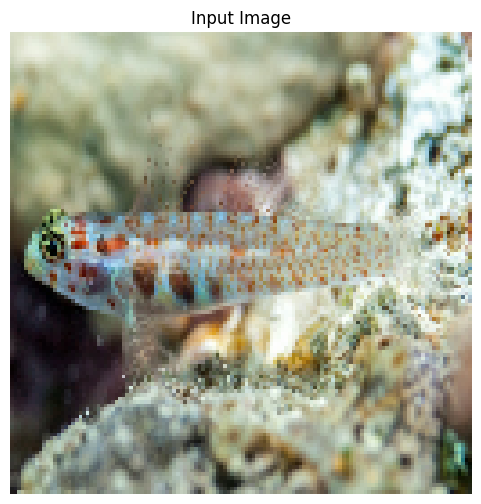

Top 3 Family Predictions:
b'Gobiidae': 0.7654
b'Tripterygiidae': 0.2059
b'Chaenopsidae': 0.0101

Top 3 Genus Predictions:
b'Eviota': 0.5872
b'Ucla': 0.1101
b'Koumansetta': 0.0398

Top 3 Species Predictions:
b'Ucla xenogrammus': 0.1687
b'Koumansetta rainfordi': 0.0885
b'Helcogramma fuscopinna': 0.0874


In [15]:
image_path = '/Users/leonardo/Documents/Projects/cryptovision/data/processed/cv_images_dataset/Gobiidae_Eviota_melasma/web_Eviota_melasma_41.jpeg'

top_k_family, top_k_genus, top_k_species = predict_image(
    image_path, model, family_labels, genus_labels, species_labels, top_k=3, image_size=settings['img_size']
)

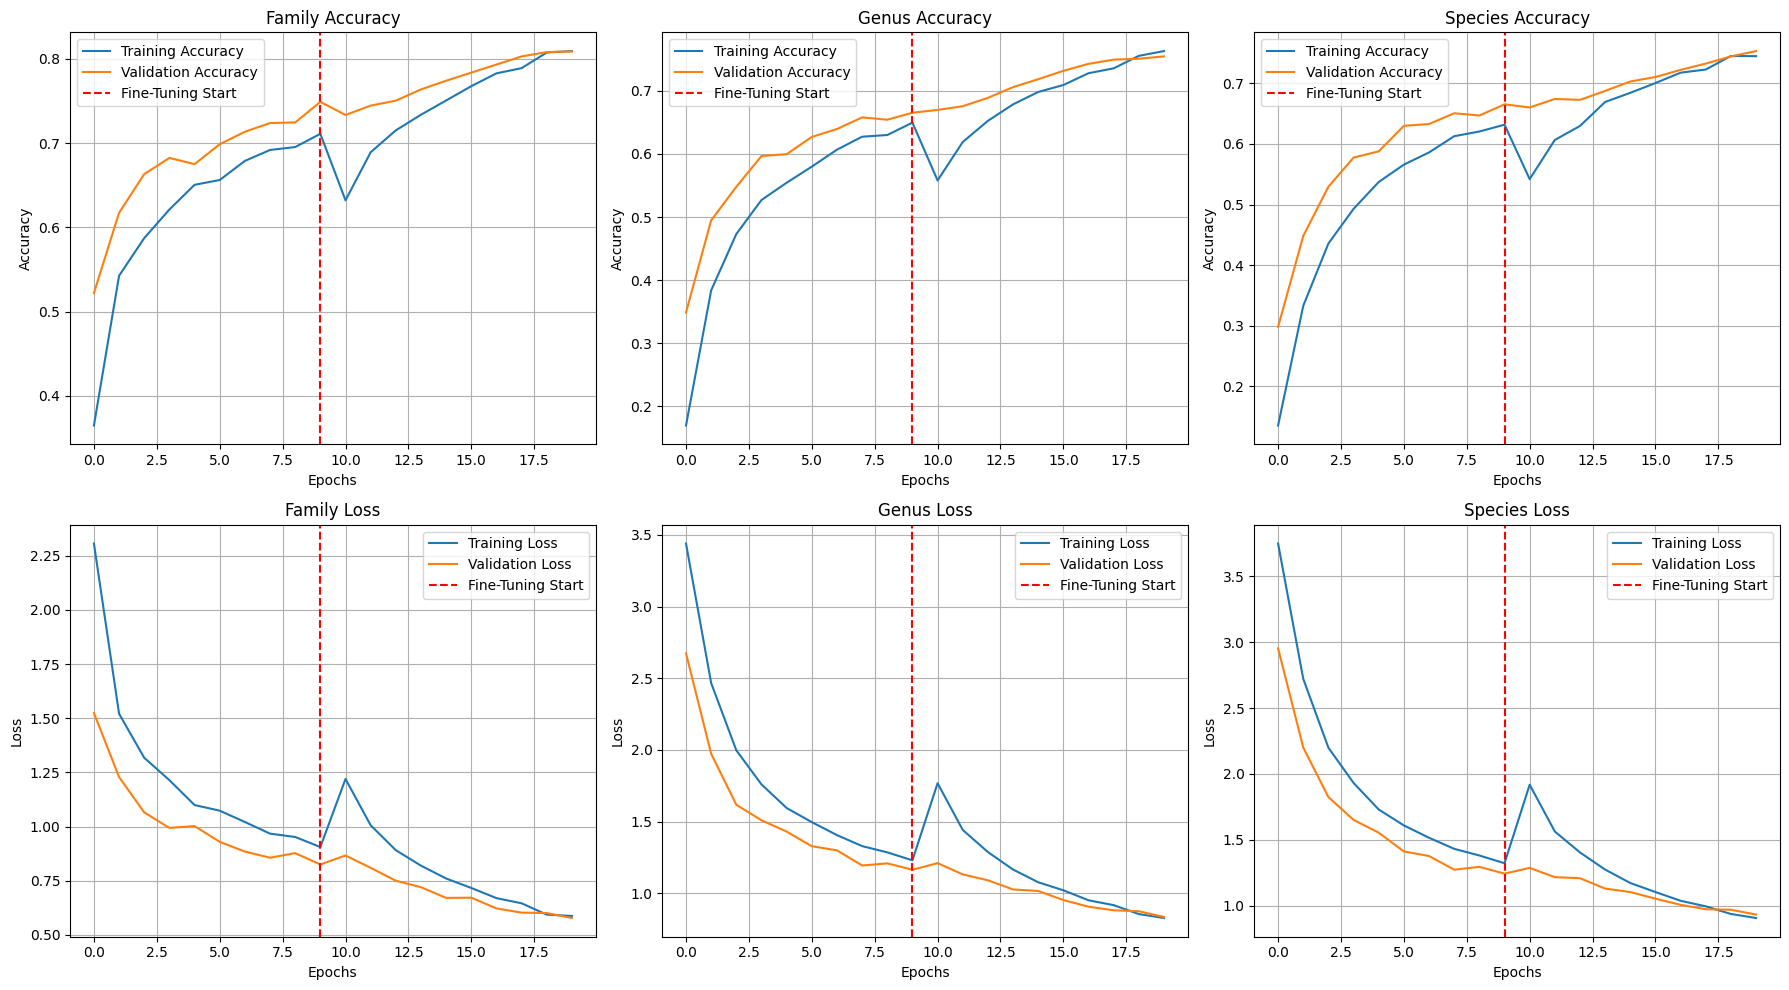

In [16]:
plot_training_history(history, history_fine, fine_tune_at=settings['epochs']-1)

In [17]:
import os
import numpy as np
from collections import defaultdict
import pandas as pd
import tensorflow as tf

def get_taxonomic_mappings_from_folders(data_dir):
    """
    Extract family, genus, and species mappings from the dataset folder structure.
    
    Args:
    - data_dir (str): Path to the training dataset directory.
    
    Returns:
    - family_labels (list): List of unique family names.
    - genus_labels (list): List of unique genus names.
    - species_labels (list): List of unique species names.
    - genus_to_family (dict): Mapping of genus to family.
    - species_to_genus (dict): Mapping of species to genus.
    """
    family_labels = set()
    genus_labels = set()
    species_labels = set()
    genus_to_family = {}
    species_to_genus = {}

    # Iterate through the folders in the data directory
    for folder_name in os.listdir(data_dir):
        # Assume folder names are in the format "family_genus_species"
        parts = folder_name.split('_')
        if len(parts) == 3:
            family, genus, species = parts
            family_labels.add(family)
            genus_labels.add(genus)
            species_full = f"{genus}_{species}"
            species_labels.add(species_full)

            # Map genus to family
            genus_to_family[genus] = family

            # Map species to genus
            species_to_genus[species_full] = genus

    # Sort the labels to maintain consistent ordering
    family_labels = sorted(list(family_labels))
    genus_labels = sorted(list(genus_labels))
    species_labels = sorted(list(species_labels))

    return family_labels, genus_labels, species_labels, genus_to_family, species_to_genus

def analyze_taxonomic_misclassifications(model, dataset, family_labels, genus_labels, species_labels, genus_to_family, species_to_genus):
    """
    Analyze misclassifications of a trained model to check if taxonomic hierarchies are respected.
    
    Args:
    - model (tf.keras.Model): The trained model.
    - dataset (tf.data.Dataset): Validation or test dataset.
    - family_labels, genus_labels, species_labels (list): List of class labels for family, genus, and species.
    - genus_to_family (dict): Mapping of genus to family.
    - species_to_genus (dict): Mapping of species to genus.
    
    Returns:
    - summary (dict): A dictionary containing summary of misclassifications.
    - genus_df (DataFrame): DataFrame with genus misclassification details.
    - species_df (DataFrame): DataFrame with species misclassification details.
    """
    # Counters for misclassifications
    genus_misclassifications = defaultdict(int)
    genus_respect_family = 0
    genus_total_mistakes = 0

    species_misclassifications = defaultdict(int)
    species_respect_genus = 0
    species_respect_family = 0
    species_total_mistakes = 0

    # Iterate over the dataset to collect predictions and true labels
    for images, labels in dataset:
        # Get the logits from the model for each output (family, genus, species)
        family_logits, genus_logits, species_logits = model(images, training=False)

        # Get true and predicted labels for each level
        true_family_indices = tf.argmax(labels['family'], axis=1).numpy()
        true_genus_indices = tf.argmax(labels['genus'], axis=1).numpy()
        true_species_indices = tf.argmax(labels['species'], axis=1).numpy()

        pred_family_indices = np.argmax(family_logits, axis=1)
        pred_genus_indices = np.argmax(genus_logits, axis=1)
        pred_species_indices = np.argmax(species_logits, axis=1)

        # Analyze genus misclassifications
        for true_genus_idx, pred_genus_idx in zip(true_genus_indices, pred_genus_indices):
            if true_genus_idx != pred_genus_idx:
                genus_total_mistakes += 1
                true_genus = genus_labels[true_genus_idx]
                pred_genus = genus_labels[pred_genus_idx]

                # Count the misclassification
                genus_misclassifications[(true_genus, pred_genus)] += 1

                # Check if the misclassified genus is in the same family
                true_family = genus_to_family[true_genus]
                pred_family = genus_to_family.get(pred_genus, None)  # Use .get() in case pred_genus is missing
                if true_family == pred_family:
                    genus_respect_family += 1

        # Analyze species misclassifications
        for true_species_idx, pred_species_idx in zip(true_species_indices, pred_species_indices):
            if true_species_idx != pred_species_idx:
                species_total_mistakes += 1
                true_species = species_labels[true_species_idx]
                pred_species = species_labels[pred_species_idx]

                # Count the misclassification
                species_misclassifications[(true_species, pred_species)] += 1

                # Check if the misclassified species is in the same genus
                true_genus = species_to_genus[true_species]
                pred_genus = species_to_genus.get(pred_species, None)
                if true_genus == pred_genus:
                    species_respect_genus += 1

                # Check if the misclassified species is in the same family
                true_family = genus_to_family[true_genus]
                pred_family = genus_to_family.get(pred_genus, None)
                if true_family == pred_family:
                    species_respect_family += 1

    # Calculate percentages of misclassifications that respect the hierarchy
    genus_hierarchy_respect_pct = (genus_respect_family / genus_total_mistakes) * 100 if genus_total_mistakes > 0 else 0
    species_hierarchy_respect_genus_pct = (species_respect_genus / species_total_mistakes) * 100 if species_total_mistakes > 0 else 0
    species_hierarchy_respect_family_pct = (species_respect_family / species_total_mistakes) * 100 if species_total_mistakes > 0 else 0

    # Create a summary of the analysis
    summary = {
        'genus_total_mistakes': genus_total_mistakes,
        'genus_hierarchy_respect': genus_respect_family,
        'genus_hierarchy_respect_pct': genus_hierarchy_respect_pct,
        'genus_misclassifications': dict(genus_misclassifications),
        'species_total_mistakes': species_total_mistakes,
        'species_hierarchy_respect_genus': species_respect_genus,
        'species_hierarchy_respect_genus_pct': species_hierarchy_respect_genus_pct,
        'species_hierarchy_respect_family': species_respect_family,
        'species_hierarchy_respect_family_pct': species_hierarchy_respect_family_pct,
        'species_misclassifications': dict(species_misclassifications),
    }

    # Convert misclassification dictionaries to DataFrames for better readability
    genus_df = pd.DataFrame(
        [(true, pred, count) for (true, pred), count in genus_misclassifications.items()],
        columns=['True Genus', 'Predicted Genus', 'Count']
    ).sort_values(by='Count', ascending=False)

    species_df = pd.DataFrame(
        [(true, pred, count) for (true, pred), count in species_misclassifications.items()],
        columns=['True Species', 'Predicted Species', 'Count']
    ).sort_values(by='Count', ascending=False)

    # Print the summaries
    print(f"Genus Misclassifications: {genus_total_mistakes}")
    print(f"Genus Misclassifications Respecting Family: {genus_respect_family} ({genus_hierarchy_respect_pct:.2f}%)")
    print(f"\nTop Genus Misclassifications:\n{genus_df.head(10)}")

    print(f"\nSpecies Misclassifications: {species_total_mistakes}")
    print(f"Species Misclassifications Respecting Genus: {species_respect_genus} ({species_hierarchy_respect_genus_pct:.2f}%)")
    print(f"Species Misclassifications Respecting Family: {species_respect_family} ({species_hierarchy_respect_family_pct:.2f}%)")
    print(f"\nTop Species Misclassifications:\n{species_df.head(10)}")

    return summary, genus_df, species_df

# Example usage:
# Assuming 'train_dir' is the path to the training dataset directory.
train_dir = "/Users/leonardo/Documents/Projects/cryptovision/data/processed/cv_images_dataset"
family_labels, genus_labels, species_labels, genus_to_family, species_to_genus = get_taxonomic_mappings_from_folders(train_dir)

# Now analyze the misclassifications using the mappings
summary, genus_df, species_df = analyze_taxonomic_misclassifications(
    model=model,
    dataset=test_ds,
    family_labels=family_labels,
    genus_labels=genus_labels,
    species_labels=species_labels,
    genus_to_family=genus_to_family,
    species_to_genus=species_to_genus
)

Genus Misclassifications: 333
Genus Misclassifications Respecting Family: 76 (22.82%)

Top Genus Misclassifications:
        True Genus Predicted Genus  Count
26      Fusigobius      Istigobius     13
7   Corythoichthys      Istigobius     10
11         Chromis    Canthigaster      8
24       Gomphosus    Canthigaster      5
29  Corythoichthys    Canthigaster      5
12         Chromis     Pomacanthus      5
50     Cirripectes        Gobiodon      4
61      Istigobius      Fusigobius      4
40    Ostorhinchus    Pristiapogon      4
51         Chromis       Gomphosus      4

Species Misclassifications: 353
Species Misclassifications Respecting Genus: 18 (5.10%)
Species Misclassifications Respecting Family: 91 (25.78%)

Top Species Misclassifications:
                      True Species              Predicted Species  Count
21            Fusigobius_neophytus           Istigobius_decoratus     11
33   Corythoichthys_flavofasciatus           Istigobius_decoratus      9
25                Gomp

2024-10-29 11:26:02.861716: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
